In [229]:
# load packages
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import os
from datetime import datetime
from sklearn.datasets import make_spd_matrix
from torch.utils.data import random_split, DataLoader
from scipy.stats import qmc
import time

In [230]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

In [231]:
def integration_points(n_int):
    points = torch.linspace(0, 4, n_int+1)[:-1]
    points += torch.rand(points.shape) * (1 / n_int) + np.random.rand() * 0.05 # random shift

    # points on square
    epsilon = 0.1 # changeable: set the boundary an espilon away from the Omega boundary
    side = 2 + 2*epsilon
    middle = torch.tensor((0,0)).view(1,2)
    points = torch.remainder(points, 4) # transform points to [0,4]
    v1 = torch.tensor((0, side))[None,]
    v2 = torch.tensor((side, 0))[None,]
    v3 = torch.tensor((0, -side))[None,]
    v4 = torch.tensor((-side, 0))[None,]
    points = points.view(-1,1)
    x_int = (middle - 0.5 * (v1 + v2) + torch.clamp(points,0,1) * v1 + torch.clamp(points-1,0,1) * v2 + torch.clamp(points-2,0,1) * v3 + torch.clamp(points-3,0,1) * v4).requires_grad_(True)

    return x_int

In [232]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x):

    middle = torch.tensor((0,0)).view(1,2)
    max_indices = torch.argmax(torch.abs(x - middle), dim=-1, keepdim=False)
    normals = torch.zeros_like(x)
    sign = torch.sign(x)
    temp_range = torch.arange(x.size(0))
    normals[temp_range, max_indices] = sign[temp_range, max_indices]

    return normals


In [233]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)

    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

In [ ]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers, n_int):

        super().__init__()
        activation = nn.Tanh
        self.n_int = n_int

        # input / start layer
        self.fc_start = nn.Sequential(*[
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ])
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)

    #------------------------------
    # forward pass through network
    def forward(self, x):
        # map x to [-1,1]
        epsilon = 0.1
        x_scaled = 2*(x - torch.tensor([-1-epsilon, -1-epsilon]))/(torch.tensor([1+epsilon, 1+epsilon]) - torch.tensor([-1-epsilon, -1-epsilon])) - 1
        #x_scaled = 2*(x - torch.tensor([x_min, y_min]))/(torch.tensor([x_max, y_max]) - torch.tensor([x_min, y_min])) - 1
        # forward pass
        x_scaled = self.fc_start(x_scaled)  # input layer
        x_scaled = self.fc_hidden(x_scaled) # hidden layer(s)
        u = self.fc_end(x_scaled)    # output layer
        return u

    #------------------------------
    # calculating the potential integrals
    def resample(self):
        # sampling new collocation and integration points
        self.x_int = integration_points(self.n_int)
        # calculating the potential
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')

    #------------------------------
    # calculating the single and double layer potentials for x being an inside Omega point
    def calc_potentials_inside(self, x):

        epsilon = 0.1
        side = 2 + 2*epsilon

        y = self.x_int
        normal_y = outer_normal(y)
        h_y = self(y) # boundary density, performs forward pass through  neural network with the input y

        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(h_y)
        dh_dy = torch.autograd.grad(h_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dh_dn = torch.sum(dh_dy * normal_y, dim=1).view(-1, 1)
        single_layer = 4*side*torch.mean(G * dh_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = 4*side*torch.mean(dG_dn * h_y)

        #################
        # source term
        f =  32*((1 - y[:,1])*y[:,1] + (1 - y[:,0])*y[:,0]) 
        source_term = torch.mean(f)

        return single_layer.squeeze(), double_layer.squeeze(), source_term.squeeze()

    #------------------------------
    def predict_u_inside(self, x):
        single_layer, double_layer, source_term = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze() + source_term.squeeze()).view(-1, 1)
        return u_int_data

In [235]:
def initialise_pibi(lr, n_int):

    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 64 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers, n_int)
    
    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error
    
    return pibi, optimiser, mse_loss

In [236]:
# Número de muestras a generar (para malla regular y para LHS)
n_samples = 30 # number of samples
n_int = 400 # number of integration points

# Crear malla regular en el dominio [0,1]x[0,1]
x = np.linspace(-1, 1, n_samples)
y = np.linspace(-1, 1, n_samples)
X_grid, Y_grid = np.meshgrid(x, y)

# Evaluar solución analítica sobre la malla regular
U_grid = u_analytic(X_grid, Y_grid)

# Aplanar y combinar en una matriz (x, y, u) para la malla regular
num_points = n_samples ** 2
XU_grid = np.column_stack((
    X_grid.reshape(num_points),
    Y_grid.reshape(num_points),
    U_grid.reshape(num_points)
))

# Generar muestras usando Latin Hypercube Sampling (LHS)
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_samples = lhs_sampler.random(n=n_samples)

# Escalar las muestras al dominio [0,1]x[0,1]
domain_bounds_lower = [0, 0]
domain_bounds_upper = [1, 1]
lhs_scaled = qmc.scale(lhs_samples, domain_bounds_lower, domain_bounds_upper)

# Evaluar solución analítica en las muestras LHS
X_lhs, Y_lhs = lhs_scaled[:, 0], lhs_scaled[:, 1]
U_lhs = u_analytic(X_lhs, Y_lhs)

# Combinar en una matriz (x, y, u) para las muestras LHS
XU_lhs = np.column_stack((X_lhs, Y_lhs, U_lhs))

# generar puntos de integración
x_int = integration_points(n_int)


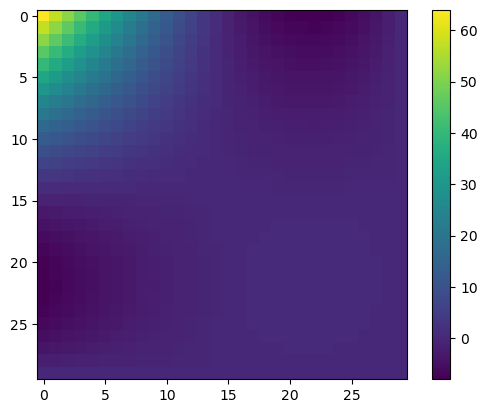

In [237]:
plt.imshow(U_grid)
plt.colorbar()
plt.show()

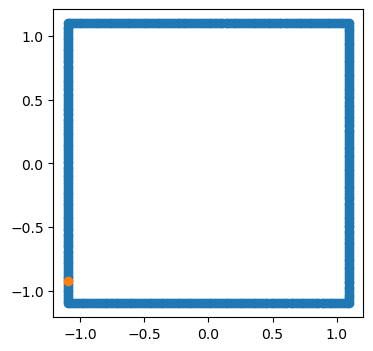

In [238]:
# plot outer normal and x_int
figure, ax = plt.subplots(figsize=(4, 4))
plt.scatter(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy())
plt.scatter(x_int[5, 0].detach().numpy(), x_int[5, 1].detach().numpy())
plt.show()
#plt.quiver(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy(), outer_normal(x_int)[:, 0].detach().numpy(), outer_normal(x_int)[:, 1].detach().numpy())

In [239]:
def train_pibi(iterations, pibi, optimiser, mse_loss, data, data_n, n_samples, n_int, time_now, show_plots):

    # store loss values
    loss_values = []
 
    for epoch in range(iterations):

        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()

        # compute data loss
        pibi.resample()
        u_int_data = pibi.predict_u_inside(data[:,0:2])
        loss = mse_loss(u_int_data, data[:,-1].view(-1,1))
        loss_values.append(loss.item())

        # backpropagate loss, take optimiser step
        loss.backward()
        optimiser.step()
        print('Epoch:', epoch, 'Loss:', loss.item())

    return pibi, loss_values

In [240]:
show_plots = True

# take samples
time_now = datetime.now().strftime("%Y%m%d_%H%M")
data = torch.tensor(XU_lhs, dtype=torch.float64)
data_ = torch.tensor(XU_grid, dtype=torch.float64)

# pibi initialisation
lr = 0.001 # learning rate
pibi, optimiser, mse_loss = initialise_pibi(lr, n_int)
    
# train pibi-net
iterations = 1_001
pibi, loss_values = train_pibi(iterations, pibi, optimiser, mse_loss, data, 00, n_samples, n_int, time_now, show_plots)

Epoch: 0 Loss: 92034444324.69937
Epoch: 1 Loss: 92050599286.88911
Epoch: 2 Loss: 92038761003.72147
Epoch: 3 Loss: 91995489731.53201
Epoch: 4 Loss: 92047918926.91904
Epoch: 5 Loss: 92044956186.25185
Epoch: 6 Loss: 92004694820.30927
Epoch: 7 Loss: 92028433353.7456
Epoch: 8 Loss: 91977867513.26793
Epoch: 9 Loss: 92057383994.31561
Epoch: 10 Loss: 92001958388.11426
Epoch: 11 Loss: 92031771963.46214
Epoch: 12 Loss: 91997475768.31195
Epoch: 13 Loss: 92044955665.31453
Epoch: 14 Loss: 92099940231.82094
Epoch: 15 Loss: 91996877175.25621
Epoch: 16 Loss: 91971975471.79646
Epoch: 17 Loss: 92037753635.6665
Epoch: 18 Loss: 92098650176.56136
Epoch: 19 Loss: 92025164700.70921
Epoch: 20 Loss: 92028539896.11484
Epoch: 21 Loss: 91944940853.09766
Epoch: 22 Loss: 91962892307.7892
Epoch: 23 Loss: 92079082837.67813
Epoch: 24 Loss: 91987956841.40163
Epoch: 25 Loss: 92112569550.94955
Epoch: 26 Loss: 92085120102.3763
Epoch: 27 Loss: 92015170318.81465
Epoch: 28 Loss: 91921127333.1026
Epoch: 29 Loss: 92084114054.5

KeyboardInterrupt: 

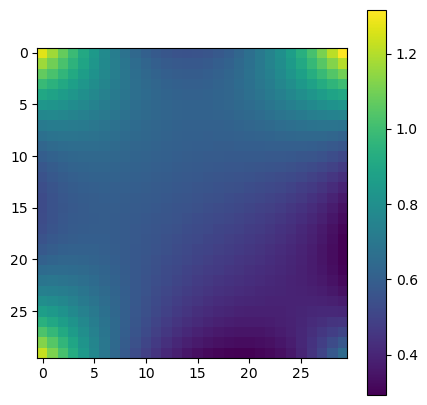

In [ ]:
data_ = torch.tensor(XU_grid, dtype=torch.float64)

u_pred = pibi.predict_u_inside(data_[:,0:2])
u_pibi = u_pred.reshape(X_grid.shape)

plt.figure(figsize=(5, 5))
plt.imshow(u_pibi.detach())
plt.colorbar()
plt.show()